In [ ]:
import pandas as pd
import os
import json
from keras.api.datasets import cifar10
from tf_keras.applications import resnet50, vgg19, mobilenet, efficientnet, mobilenet_v2
import time
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score
import math
import matplotlib.pyplot as plt
import functools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_PATH = '/content/drive/MyDrive/Robustness-backup'
RESULTS_PATH = f'{BASE_PATH}/results'

CIFAR10_C_PATH = f'{BASE_PATH}/CIFAR-10-C'

CORRUPTION_TYPES = {
    'blur': ['defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur'],
    'digital': ['contrast', 'elastic_transform', 'jpeg_compression', 'pixelate'],
    'noise': ['gaussian_noise', 'impulse_noise', 'shot_noise'],
    'weather': ['brightness', 'fog', 'frost', 'snow']
}
LEN_BY_SEVERITY_LEVEL = 10000

In [ ]:
import tempfile
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [ ]:
def generate_data_with_labels(image_dir):
    all_file_paths = []
    labels = []

    all_folds = os.listdir(image_dir)
    for fold in all_folds:
        fold_path = os.path.join(image_dir, fold)
        all_files_in_fold = os.listdir(fold_path)
        for file in all_files_in_fold:
            file_path = os.path.join(fold_path, file)
            all_file_paths.append(file_path)
            labels.append(fold)
    return pd.DataFrame(data={"file_path": all_file_paths, "labels": labels})


def save_json(output_name, data_dict):
    with open(output_name, 'w') as file:
        json.dump(data_dict, file)
    print("File save with success!")


def load_json(output_name):
    with open(output_name, 'r') as file:
        data_dict = json.load(file)
    print("File loaded with success!")

    return data_dict

In [ ]:
def sum_levels(category_data):
    return {key: sum(levels.values()) for key, levels in category_data.items()}

def sum_corruption_error_by_corruption(corruption_error_data):
    return {category: sum_levels(corruption_error_data[category]) for category in corruption_error_data}

def sum_levels_relative(category_data, baseline_clean_error):
    result = {}
    for key, levels in category_data.items():
        total_sum = 0.
        for corruption_value in levels.values():
            total_sum += corruption_value - baseline_clean_error
        result[key] = total_sum
    return result


def sum_relative_corruption_error(corruption_error_data, baseline_clean_error):
    return {category: sum_levels_relative(corruption_error_data[category], baseline_clean_error) for category in
            corruption_error_data}


def generate_relative_and_corruption_error(sum_ce_model, sum_rel_ce_model, sum_ce_baseline, sum_rel_ce_baseline):
    ce_result = {}
    relative_ce_result = {}
    for key, corruptions in CORRUPTION_TYPES.items():
        for corruption in corruptions:
            corruption_error = sum_ce_model[key][corruption] / sum_ce_baseline[key][corruption]
            relative_corruption_error = sum_rel_ce_model[key][corruption] / sum_rel_ce_baseline[key][corruption]
            ce_result[corruption] = round(corruption_error * 100)
            relative_ce_result[corruption] = round(relative_corruption_error * 100)

    ce_result['mCE'] = round(sum(ce_result.values()) / 15, 1)
    relative_ce_result['Relative mCE'] = round(sum(relative_ce_result.values()) / 15, 1)
    return ce_result, relative_ce_result

def generate_metrics(corruption_error_to_evaluate, corruption_error_baseline, CLEAN_ERROR_TO_EVALUATE, CLEAN_ERROR_BASELINE):
    sum_ce_evaluate = sum_corruption_error_by_corruption(corruption_error_to_evaluate)
    sum_relative_ce_evaluate = sum_relative_corruption_error(corruption_error_to_evaluate, CLEAN_ERROR_TO_EVALUATE)

    sum_ce_baseline = sum_corruption_error_by_corruption(corruption_error_baseline)
    sum_relative_ce_baseline = sum_relative_corruption_error(corruption_error_baseline, CLEAN_ERROR_BASELINE)

    ce_result, relative_ce_result = generate_relative_and_corruption_error(sum_ce_evaluate, sum_relative_ce_evaluate, sum_ce_baseline, sum_relative_ce_baseline)

    return ce_result, relative_ce_result

In [ ]:
def get_output_compression(PATH, types_of_model):
  all_models = os.listdir(PATH)
  output_compression = {model_name: {} for model_name in all_models}
  for model in all_models:
    fold_path = os.path.join(PATH, model, 'models')

    if not os.path.isdir(fold_path):
      continue

    types_fold_path = os.listdir(fold_path)

    for type_fold in types_fold_path:
      type_fold_path = os.path.join(fold_path, type_fold)

      all_optimizations = os.listdir(type_fold_path)
      for optimization in all_optimizations:
        optimization_path = os.path.join(type_fold_path, optimization)

        for key, value in types_of_model.items():
          type_model = value.format(model_name=model)
          if type_model == optimization:
            output_compression[model].update({key: get_gzipped_model_size(optimization_path)})
  return output_compression

def get_model_size(output_compression):
  models_size = {}
  for model, result in output_compression.items():
    if not model in models_size:
      models_size[model] = {}
    for type_name, size in result.items():
      models_size[model][type_name] = result[type_name] / (1024*1024)

  return models_size

def get_compression_rate(output_compression):
  compression_rate = {}
  for model, result in output_compression.items():
    if not model in compression_rate:
      compression_rate[model] = {}
    for type_name, size in result.items():
      compression_rate[model][type_name] = (result['Original'] if 'Original' in result else 0)/ size

  return compression_rate

def generate_df_compression(compression_rate):
  flattened_data = []

  for model_name, model_data in compression_rate.items():
    for type_name, value in model_data.items():
        row = {'Model': model_name, 'Type': type_name, 'Compression Rate': value}
        flattened_data.append(row)
  df_compression = pd.DataFrame(flattened_data)
  df_compression.set_index(['Model', 'Type'], inplace=True)

  return df_compression

In [ ]:
PATH_CIFAR_100 = f"{BASE_PATH}/cifar100/optimization"
PATH_CIFAR_10 = f"{BASE_PATH}/cifar10/optimization"

In [ ]:
types_of_model = {
    "Original": '{model_name}.tflite',
    'Quantization Int8': '{model_name}-full_integer.tflite',
    'Pruning': '{model_name}-pruning-50.tflite',
    'Pruning with Quantization Int8': '{model_name}-pruning-50-full_integer.tflite',
    'Clustering': '{model_name}-clustering-16.tflite',
    'Clustering with Quantization Int8': '{model_name}-clustering-16-full_integer.tflite',
    'Pruning with Clustering': '{model_name}-pruning-50-clustering-16.tflite',
    'Pruning with Clustering with Quantization Int8': '{model_name}-pruning-50-clustering-16-full_integer.tflite',
    'QAT':'{model_name}-qat.tflite',
    'QAT with Quantization Int8': '{model_name}-qat-full_integer.tflite',
    'CQAT': '{model_name}-clustering-16-qat.tflite',
    'CQAT with Quantization Int8': '{model_name}-clustering-16-qat-full_integer.tflite',
    'PQAT': '{model_name}-pruning-50-qat.tflite',
    'PQAT with Quantization Int8': '{model_name}-pruning-50-qat-full_integer.tflite',
    'PCQAT': '{model_name}-pruning-50-clustering-16-qat.tflite',
    'PCQAT with Quantization Int8': '{model_name}-pruning-50-clustering-16-qat-full_integer.tflite',
}


cifar10_out_compression = get_output_compression(PATH_CIFAR_10, types_of_model)
cifar100_out_compression = get_output_compression(PATH_CIFAR_100, types_of_model)

cifar10_out_compression, cifar100_out_compression

({'vgg19': {'Clustering': 12329830,
   'Clustering with Quantization Int8': 10161126,
   'Original': 76385326,
   'Quantization Int8': 16081298,
   'QAT': 27421173,
   'QAT with Quantization Int8': 15992598,
   'Pruning': 46405995,
   'Pruning with Quantization Int8': 12318615,
   'Pruning with Clustering': 10685446,
   'Pruning with Clustering with Quantization Int8': 8495103,
   'CQAT': 13266043,
   'CQAT with Quantization Int8': 9925282,
   'PQAT': 19922503,
   'PQAT with Quantization Int8': 12271171,
   'PCQAT': 10938782,
   'PCQAT with Quantization Int8': 8102033},
  'mobilenet': {'Clustering': 3812331,
   'Clustering with Quantization Int8': 2600555,
   'Original': 15815720,
   'Quantization Int8': 4027680,
   'QAT': 7555068,
   'QAT with Quantization Int8': 3900098,
   'Pruning': 9689434,
   'Pruning with Quantization Int8': 2947114,
   'Pruning with Clustering': 3186748,
   'Pruning with Clustering with Quantization Int8': 2142365,
   'CQAT': 4001172,
   'CQAT with Quantization

In [ ]:
cifar10_out_compression, cifar100_out_compression = ({'vgg19': {'Clustering': 12329830,
   'Clustering with Quantization Int8': 10161126,
   'Original': 76385326,
   'Quantization Int8': 16081298,
   'QAT': 27421173,
   'QAT with Quantization Int8': 15992598,
   'Pruning': 46405995,
   'Pruning with Quantization Int8': 12318615,
   'Pruning with Clustering': 10685446,
   'Pruning with Clustering with Quantization Int8': 8495103,
   'CQAT': 13266043,
   'CQAT with Quantization Int8': 9925282,
   'PQAT': 19922503,
   'PQAT with Quantization Int8': 12271171,
   'PCQAT': 10938782,
   'PCQAT with Quantization Int8': 8102033},
  'mobilenet': {'Clustering': 3812331,
   'Clustering with Quantization Int8': 2600555,
   'Original': 15815720,
   'Quantization Int8': 4027680,
   'QAT': 7555068,
   'QAT with Quantization Int8': 3900098,
   'Pruning': 9689434,
   'Pruning with Quantization Int8': 2947114,
   'Pruning with Clustering': 3186748,
   'Pruning with Clustering with Quantization Int8': 2142365,
   'CQAT': 4001172,
   'CQAT with Quantization Int8': 2682931,
   'PQAT': 5472298,
   'PQAT with Quantization Int8': 2863712,
   'PCQAT': 3246743,
   'PCQAT with Quantization Int8': 2045040},
  'resnet50': {'Clustering': 20987074,
   'Clustering with Quantization Int8': 14644412,
   'Original': 95132457,
   'Quantization Int8': 22983417,
   'QAT': 43170122,
   'QAT with Quantization Int8': 22626984,
   'Pruning': 58097621,
   'Pruning with Quantization Int8': 16827829,
   'Pruning with Clustering': 17514882,
   'Pruning with Clustering with Quantization Int8': 12040274,
   'CQAT': 21922372,
   'CQAT with Quantization Int8': 15024616,
   'PQAT': 30445088,
   'PQAT with Quantization Int8': 16606388,
   'PCQAT': 17439476,
   'PCQAT with Quantization Int8': 11700407},
  'results-full.xlsx': {},
  'mobilenet_v2': {'Pruning': 8085552,
   'Pruning with Quantization Int8': 2549566,
   'Clustering': 3560806,
   'Clustering with Quantization Int8': 2266576,
   'Original': 13110855,
   'Quantization Int8': 3533541,
   'QAT': 7045664,
   'QAT with Quantization Int8': 3502339,
   'CQAT': 3723629,
   'CQAT with Quantization Int8': 2426030,
   'Pruning with Clustering': 2954094,
   'Pruning with Clustering with Quantization Int8': 1899093,
   'PQAT': 5044888,
   'PQAT with Quantization Int8': 2526144,
   'PCQAT': 2752912,
   'PCQAT with Quantization Int8': 1675044},
  'results_cifar_10.xlsx': {}},
 {'results_cifar_100 (3).xlsx': {},
  'resnet50': {'Pruning': 58309437,
   'Pruning with Quantization Int8': 16622144,
   'Clustering': 20588101,
   'Clustering with Quantization Int8': 14525650,
   'Original': 95495496,
   'Quantization Int8': 22472588,
   'QAT': 42595771,
   'QAT with Quantization Int8': 22426633,
   'CQAT': 21050616,
   'CQAT with Quantization Int8': 14417740,
   'Pruning with Clustering': 17171530,
   'Pruning with Clustering with Quantization Int8': 11822098,
   'PQAT': 29988213,
   'PQAT with Quantization Int8': 16613059,
   'PCQAT': 16514467,
   'PCQAT with Quantization Int8': 11105163},
  'mobilenet': {'Pruning': 9919852,
   'Pruning with Quantization Int8': 2994507,
   'Clustering': 3847469,
   'Clustering with Quantization Int8': 2609044,
   'Original': 16160413,
   'Quantization Int8': 4081640,
   'QAT': 7778233,
   'QAT with Quantization Int8': 4029001,
   'CQAT': 3852608,
   'CQAT with Quantization Int8': 2476512,
   'Pruning with Clustering': 3105241,
   'Pruning with Clustering with Quantization Int8': 2109752,
   'PQAT': 5615430,
   'PQAT with Quantization Int8': 2960082,
   'PCQAT': 3048375,
   'PCQAT with Quantization Int8': 1960321},
  'vgg19': {'Pruning': 46448072,
   'Pruning with Quantization Int8': 12780371,
   'Clustering': 13773496,
   'Clustering with Quantization Int8': 11030331,
   'Original': 76797472,
   'Quantization Int8': 16942819,
   'QAT': 29713759,
   'QAT with Quantization Int8': 16942805,
   'CQAT': 14345498,
   'CQAT with Quantization Int8': 10596593,
   'Pruning with Clustering': 11703553,
   'Pruning with Clustering with Quantization Int8': 8960753,
   'PQAT': 21333697,
   'PQAT with Quantization Int8': 12841794,
   'PCQAT': 11454965,
   'PCQAT with Quantization Int8': 8308624},
  'mobilenet_v2': {'Pruning': 8300263,
   'Pruning with Quantization Int8': 2616884,
   'Clustering': 3672249,
   'Clustering with Quantization Int8': 2318076,
   'Original': 13452693,
   'Quantization Int8': 3617114,
   'QAT': 7142891,
   'QAT with Quantization Int8': 3572511,
   'CQAT': 3608092,
   'CQAT with Quantization Int8': 2270217,
   'Pruning with Clustering': 2995397,
   'Pruning with Clustering with Quantization Int8': 1897794,
   'PQAT': 5081400,
   'PQAT with Quantization Int8': 2582010,
   'PCQAT': 2612985,
   'PCQAT with Quantization Int8': 1570681}})

In [ ]:
cifar10_compression_rate = get_compression_rate(cifar10_out_compression)
cifar100_compression_rate = get_compression_rate(cifar100_out_compression)

df_cifar10_compression = generate_df_compression(cifar10_compression_rate)
df_cifar100_compression = generate_df_compression(cifar100_compression_rate)

In [ ]:
df_cifar10_compression, df_cifar100_compression

(                                                             Compression Rate
 Model        Type                                                            
 vgg19        Clustering                                              6.195165
              Clustering with Quantization Int8                       7.517408
              Original                                                1.000000
              Quantization Int8                                       4.749948
              QAT                                                     2.785633
 ...                                                                       ...
 mobilenet_v2 Pruning with Clustering with Quantization Int8          6.903746
              PQAT                                                    2.598840
              PQAT with Quantization Int8                             5.190066
              PCQAT                                                   4.762541
              PCQAT with Quantization Int8          

In [ ]:
def load_outputs(PATH, types_of_model):
  def is_result_complete(result):
    for corruption_type in CORRUPTION_TYPES.keys():
      for corruption in CORRUPTION_TYPES[corruption_type]:
        if not corruption in result['corruptions'][corruption_type]:
          return False
    return True
  all_models = os.listdir(PATH)
  all_models = list(filter(lambda x: os.path.isdir(f'{PATH}/{x}'), all_models))
  output = {
      'accuracy': {model_name: {} for model_name in all_models},
      'mce': {model_name: {} for model_name in all_models},
      'relative mce': {model_name: {} for model_name in all_models},
  }

  raw_data = {model_name: {} for model_name in all_models}
  for model_name in all_models:
    original_file_name = types_of_model["Original"].format(model_name=model_name)
    original_path = f'{PATH}/{model_name}/results/{original_file_name}'
    if not os.path.exists(original_path):
      continue
    result_original = load_json(f'{PATH}/{model_name}/results/{original_file_name}')

    for key, value in types_of_model.items():
      file_name = value.format(model_name=model_name)
      current_path = f'{PATH}/{model_name}/results/{file_name}'

      if os.path.exists(current_path) and is_result_complete(load_json(current_path)):
        result = load_json(current_path)
        mce, relative_mce = generate_metrics(
            result['corruptions'],
            result_original['corruptions'],
            result['clean'],
            result_original['clean']
        )
        output['accuracy'][model_name].update({key: 1 - result['clean']})
        output['mce'][model_name].update({key: mce})
        output['relative mce'][model_name].update({key: relative_mce})
        raw_data[model_name].update({key: result})
      else:
        output['accuracy'][model_name].update({key: None})
        output['mce'][model_name].update({key: None})
        output['relative mce'][model_name].update({key: None})
        raw_data[model_name].update({key: None})

  return raw_data, output

In [ ]:
get_model_size(cifar100_out_compression)

{'results_cifar_100 (3).xlsx': {},
 'resnet50': {'Pruning': 55.6082124710083,
  'Pruning with Quantization Int8': 15.85211181640625,
  'Clustering': 19.634343147277832,
  'Clustering with Quantization Int8': 13.852739334106445,
  'Original': 91.07160186767578,
  'Quantization Int8': 21.431529998779297,
  'QAT': 40.62249279022217,
  'QAT with Quantization Int8': 21.387703895568848,
  'CQAT': 20.07543182373047,
  'CQAT with Quantization Int8': 13.749828338623047,
  'Pruning with Clustering': 16.376047134399414,
  'Pruning with Clustering with Quantization Int8': 11.274431228637695,
  'PQAT': 28.59898853302002,
  'PQAT with Quantization Int8': 15.8434476852417,
  'PCQAT': 15.749423027038574,
  'PCQAT with Quantization Int8': 10.59070873260498},
 'mobilenet': {'Pruning': 9.460308074951172,
  'Pruning with Quantization Int8': 2.8557844161987305,
  'Clustering': 3.6692323684692383,
  'Clustering with Quantization Int8': 2.488178253173828,
  'Original': 15.411770820617676,
  'Quantization Int

In [ ]:
all_preprocess_inputs = {
    'resnet50': resnet50.preprocess_input,
    'mobilenet': mobilenet.preprocess_input,
    'mobilenet_v2': mobilenet_v2.preprocess_input,
    'vgg19': vgg19.preprocess_input,

}
types_of_model = {
    "Original": 'ce_{model_name}.json',
    'Quantization Int8': 'ce_{model_name}_full_integer.json',
    'Pruning': 'ce_{model_name}_pruning_50.json',
    'Pruning with Quantization Int8': 'ce_{model_name}_pruning_50_full_integer.json',
    'Clustering': 'ce_{model_name}_clustering_16.json',
    'Clustering with Quantization Int8': 'ce_{model_name}_clustering_16_full_integer.json',
    'Pruning with Clustering': 'ce_{model_name}_pruning_50_clustering_16.json',
    'Pruning with Clustering with Quantization Int8': 'ce_{model_name}_pruning_50_clustering_16_full_integer.json',
    'QAT':'ce_{model_name}_qat.json',
    'QAT with Quantization Int8': 'ce_{model_name}_qat_full_integer.json',
    'CQAT': 'ce_{model_name}_clustering_16_qat.json',
    'CQAT with Quantization Int8': 'ce_{model_name}_clustering_16_qat_full_integer.json',
    'PQAT': 'ce_{model_name}_pruning_50_qat.json',
    'PQAT with Quantization Int8': 'ce_{model_name}_pruning_50_qat_full_integer.json',
    'PCQAT': 'ce_{model_name}_pruning_50_clustering_16_qat.json',
    'PCQAT with Quantization Int8': 'ce_{model_name}_pruning_50_clustering_16_qat_full_integer.json',
}

cifar10_raw_data, cifar10_output = load_outputs(PATH_CIFAR_10, types_of_model)
cifar100_raw_data, cifar100_output = load_outputs(PATH_CIFAR_100, types_of_model)


File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded 

In [ ]:
cifar10_output['accuracy']

{'vgg19': {'Original': 0.7224,
  'Quantization Int8': 0.7175,
  'Pruning': 0.7654,
  'Pruning with Quantization Int8': 0.7612,
  'Clustering': 0.7479,
  'Clustering with Quantization Int8': 0.7433,
  'Pruning with Clustering': 0.7557,
  'Pruning with Clustering with Quantization Int8': 0.7506,
  'QAT': 0.7605,
  'QAT with Quantization Int8': 0.6133,
  'CQAT': 0.7468,
  'CQAT with Quantization Int8': 0.7474,
  'PQAT': 0.7569,
  'PQAT with Quantization Int8': 0.757,
  'PCQAT': 0.7417,
  'PCQAT with Quantization Int8': 0.7419},
 'mobilenet': {'Original': 0.907,
  'Quantization Int8': 0.8965,
  'Pruning': 0.9434,
  'Pruning with Quantization Int8': 0.9395,
  'Clustering': 0.9288,
  'Clustering with Quantization Int8': 0.9245,
  'Pruning with Clustering': 0.9344,
  'Pruning with Clustering with Quantization Int8': 0.9323,
  'QAT': 0.9402,
  'QAT with Quantization Int8': 0.9033,
  'CQAT': 0.9321,
  'CQAT with Quantization Int8': 0.9325,
  'PQAT': 0.9434,
  'PQAT with Quantization Int8': 0.94

In [ ]:
cifar100_output['accuracy']

{'resnet50': {'Original': 0.7606,
  'Quantization Int8': 0.7567,
  'Pruning': 0.7717,
  'Pruning with Quantization Int8': 0.7657,
  'Clustering': 0.7585,
  'Clustering with Quantization Int8': 0.7428,
  'Pruning with Clustering': 0.7645,
  'Pruning with Clustering with Quantization Int8': 0.759,
  'QAT': 0.7734,
  'QAT with Quantization Int8': 0.6627,
  'CQAT': 0.7781,
  'CQAT with Quantization Int8': 0.7767,
  'PQAT': 0.7729,
  'PQAT with Quantization Int8': 0.7732,
  'PCQAT': 0.7679,
  'PCQAT with Quantization Int8': 0.7666},
 'mobilenet': {'Original': 0.7247,
  'Quantization Int8': 0.6113,
  'Pruning': 0.7355,
  'Pruning with Quantization Int8': 0.614,
  'Clustering': 0.7351,
  'Clustering with Quantization Int8': 0.6762,
  'Pruning with Clustering': 0.7308,
  'Pruning with Clustering with Quantization Int8': 0.6854,
  'QAT': 0.7501,
  'QAT with Quantization Int8': 0.5471,
  'CQAT': 0.7116,
  'CQAT with Quantization Int8': 0.7097,
  'PQAT': 0.7307,
  'PQAT with Quantization Int8': 0

In [ ]:
def build_df_accuracy(output_data):
  flattened_data = []

  for model_name, model_data in output_data["accuracy"].items():
    for type_name, value in model_data.items():
        row = {'Model': model_name, 'Type': type_name, 'Accuracy': value * 100}
        flattened_data.append(row)
  df_accuracy = pd.DataFrame(flattened_data)
  df_accuracy.set_index(['Model', 'Type'], inplace=True)

  return df_accuracy

def build_df(output_data):
  flattened_data = []

  for model_name, model_data in output_data.items():
    for type_name, metrics in model_data.items():
        row = {'Model': model_name, 'Type': type_name}
        if metrics is not None:
          row.update(metrics)
        flattened_data.append(row)
  df = pd.DataFrame(flattened_data)
  df.set_index(['Model', 'Type'], inplace=True)

  return df

In [ ]:
df_cifar10_accuracy = build_df_accuracy(cifar10_output)
df_cifar10_ce = build_df(cifar10_output['mce'])
df_cifar10_relative_ce = build_df(cifar10_output['relative mce'])

df_cifar100_accuracy = build_df_accuracy(cifar100_output)
df_cifar100_ce = build_df(cifar100_output['mce'])
df_cifar100_relative_ce = build_df(cifar100_output['relative mce'])

In [ ]:
df_cifar100_ce

defocus_blur  glass_blur  \
Model        Type                                                       
resnet50     Original                                 100         100   
             Quantization Int8                         98         100   
             Pruning                                   98          98   
             Pruning with Quantization Int8            96          98   
             Clustering                                96          97   
...                                                   ...         ...   
mobilenet_v2 CQAT with Quantization Int8              105          99   
             PQAT                                     105          95   
             PQAT with Quantization Int8              105          95   
             PCQAT                                    115          94   
             PCQAT with Quantization Int8             115          94   

                                             motion_blur  zoom_blur  contrast  \
Model        Type                                                               
resnet50     Original                                100        100       100   
             Quantization Int8                       100         98       104   
             Pruning                                  98         98        98   
             Pruning with Quantization Int8           98         97       101   
             Clustering                               99         96        99   
...                                                  ...        ...       ...   
mobilenet_v2 CQAT with Quantization Int8             106        106       119   
             PQAT                                    105        105       109   
             PQAT with Quantization Int8             105        106       109   
             PCQAT                                   115        116       120   
             PCQAT with Quantization Int8            116        117       120   

                                             elastic_transform  \
Model        Type                                                
resnet50     Original                                      100   
             Quantization Int8                              99   
             Pruning                                        98   
             Pruning with Quantization Int8                 97   
             Clustering                                     98   
...                                                        ...   
mobilenet_v2 CQAT with Quantization Int8                   104   
             PQAT                                          103   
             PQAT with Quantization Int8                   103   
             PCQAT                                         115   
             PCQAT with Quantization Int8                  115   

                                             jpeg_compression  pixelate  \
Model        Type                                                         
resnet50     Original                                     100       100   
             Quantization Int8                            100       100   
             Pruning                                       98       100   
             Pruning with Quantization Int8                99       101   
             Clustering                                    95        91   
...                                                       ...       ...   
mobilenet_v2 CQAT with Quantization Int8                  102        94   
             PQAT                                          96        98   
             PQAT with Quantization Int8                   96        98   
             PCQAT                                        100        95   
             PCQAT with Quantization Int8                 100        95   

                                             gaussian_noise  impulse_noise  \
Model        Type                                                            
resnet50     Original                             

In [ ]:
df_cifar10_final = pd.concat([df_cifar10_accuracy["Accuracy"], df_cifar10_ce["mCE"], df_cifar10_relative_ce['Relative mCE'], df_cifar10_compression['Compression Rate']], axis=1)
df_cifar100_final = pd.concat([df_cifar100_accuracy["Accuracy"], df_cifar100_ce["mCE"], df_cifar100_relative_ce['Relative mCE'], df_cifar100_compression['Compression Rate']], axis=1)


In [ ]:
df_cifar10_final

Accuracy    mCE  Relative mCE  \
Model        Type                                                            
vgg19        Original                           72.24  100.0         100.0   
             Quantization Int8                  71.75  101.5         101.7   
             Pruning                            76.54   92.1         101.1   
             Pruning with Quantization Int8     76.12   93.5         103.3   
             Clustering                         74.79   94.8          96.6   
...                                               ...    ...           ...   
mobilenet_v2 CQAT with Quantization Int8        89.41   99.0          98.5   
             PQAT                               89.60  107.4         110.4   
             PQAT with Quantization Int8        89.59  106.9         109.3   
             PCQAT                              88.44  108.2         106.9   
             PCQAT with Quantization Int8       88.22  108.1         105.4   

                                             Compression Rate  
Model        Type                                              
vgg19        Original                                1.000000  
             Quantization Int8                       4.749948  
             Pruning                                 1.646023  
             Pruning with Quantization Int8          6.200805  
             Clustering                              6.195165  
...                                                       ...  
mobilenet_v2 CQAT with Quantization Int8             5.404243  
             PQAT                                    2.598840  
             PQAT with Quantization Int8             5.190066  
             PCQAT                                   4.762541  
             PCQAT with Quantization Int8            7.827171  

[64 rows x 4 columns]

In [ ]:
df_cifar100_final

Accuracy    mCE  Relative mCE  \
Model        Type                                                            
resnet50     Original                           76.06  100.0         100.0   
             Quantization Int8                  75.67  100.4          99.9   
             Pruning                            77.17   97.9         100.0   
             Pruning with Quantization Int8     76.57   98.5          98.3   
             Clustering                         75.85   96.7          92.2   
...                                               ...    ...           ...   
mobilenet_v2 CQAT with Quantization Int8        69.00  104.8         100.1   
             PQAT                               71.08  101.0          99.9   
             PQAT with Quantization Int8        70.92  101.3          99.8   
             PCQAT                              66.86  107.9          99.9   
             PCQAT with Quantization Int8       66.69  108.1          99.1   

                                             Compression Rate  
Model        Type                                              
resnet50     Original                                1.000000  
             Quantization Int8                       4.249421  
             Pruning                                 1.637737  
             Pruning with Quantization Int8          5.745077  
             Clustering                              4.638383  
...                                                       ...  
mobilenet_v2 CQAT with Quantization Int8             5.925730  
             PQAT                                    2.647438  
             PQAT with Quantization Int8             5.210163  
             PCQAT                                   5.148400  
             PCQAT with Quantization Int8            8.564879  

[64 rows x 4 columns]

In [ ]:
df_cifar100_final.groupby(level="Type")[['mCE', 'Compression Rate','Accuracy']].std()

,mCE,Compression Rate,Accuracy
Type,,,
CQAT,6.444377,0.685417,6.055650
CQAT with Quantization Int8,6.420994,0.541085,6.006743
Clustering,0.750000,0.809259,8.226309
Clustering with Quantization Int8,5.921360,0.497979,8.328983
Original,0.000000,0.000000,8.978880
PCQAT,7.377669,0.700944,6.294521
PCQAT with Quantization Int8,7.838792,0.418721,6.319623
PQAT,4.094305,0.411932,7.026115
PQAT with Quantization Int8,4.058222,0.335810,7.070457


## Number of values with mCE below or equal to 100.
Subtraction by 3, to take the original values of the 3 models

In [ ]:
result = df_cifar100_final[df_cifar100_final["mCE"] <= 100]
result = result[~(result.index.get_level_values('Model') == 'mobilenet')]
result.shape[0] - 3

31

## Which techniques were bad/good for the 3 models
Example: QAT was bad for the 3 models, while PCQAT was good for the 3 models

In [ ]:
result = df_cifar100_final[df_cifar100_final["mCE"] > 100]
result = result[~(result.index.get_level_values('Model') == 'mobilenet')]
result = result.reset_index()

tecnique_count = result.groupby('Type')['Model'].nunique()

all_fill_technique = tecnique_count[tecnique_count == 3].index
resultado = df_cifar100_final.loc[(slice(None), all_fill_technique), :]

resultado

,,Accuracy,mCE,Relative mCE,Compression Rate
Model,Type,,,,
resnet50,Quantization Int8,75.67,100.4,99.9,4.249421
mobilenet,Quantization Int8,61.13,124.7,114.0,3.959294
vgg19,Quantization Int8,55.27,100.2,97.2,4.532745
mobilenet_v2,Quantization Int8,65.66,110.7,99.4,3.719179


In [ ]:
result = df_cifar100_final[df_cifar100_final["mCE"] <= 100]
result = result[~(result.index.get_level_values('Model') == 'mobilenet')]
result = result.reset_index()

tecnique_count = result.groupby('Type')['Model'].nunique()

all_fill_technique = tecnique_count[tecnique_count == 3].index
resultado = df_cifar100_final.loc[(slice(None), all_fill_technique), :]

# resultado
all_fill_technique

Index(['Clustering', 'Original', 'Pruning', 'Pruning with Clustering', 'QAT'], dtype='object', name='Type')

In [ ]:
df_cifar100_final.sort_values(by='Accuracy')

Accuracy    mCE  \
Model     Type                                                              
vgg19     Pruning with Clustering with Quantization Int8     54.11   99.7   
          QAT with Quantization Int8                         54.42   99.7   
          Clustering with Quantization Int8                  54.59   98.7   
mobilenet QAT with Quantization Int8                         54.71  130.1   
vgg19     Quantization Int8                                  55.27  100.2   
...                                                            ...    ...   
resnet50  PQAT                                               77.29   95.1   
          PQAT with Quantization Int8                        77.32   95.4   
          QAT                                                77.34   97.5   
          CQAT with Quantization Int8                        77.67   95.4   
          CQAT                                               77.81   95.5   

                                                          Relative mCE  \
Model     Type                                                           
vgg19     Pruning with Clustering with Quantization Int8          90.1   
          QAT with Quantization Int8                              92.9   
          Clustering with Quantization Int8                       86.7   
mobilenet QAT with Quantization Int8                              98.8   
vgg19     Quantization Int8                                       97.2   
...                                                                ...   
resnet50  PQAT                                                    95.4   
          PQAT with Quantization Int8                             96.5   
          QAT                                                    100.7   
          CQAT with Quantization Int8                             97.7   
          CQAT                                                    98.5   

                                                          Compression Rate  
Model     Type                                                              
vgg19     Pruning with Clustering with Quantization Int8          8.570426  
          QAT with Quantization Int8                              4.532748  
          Clustering with Quantization Int8                       6.962391  
mobilenet QAT with Quantization Int8                              4.011022  
vgg19     Quantization Int8                                       4.532745  
...                                                                    ...  
resnet50  PQAT                                                    3.184434  
          PQAT with Quantization Int8                             5.748219  
          QAT                                                     2.241901  
          CQAT with Quantization Int8                             6.623472  
          CQAT                                                    4.536470  

[64 rows x 4 columns]

In [ ]:
df_cifar10_final.to_excel('results_cifar_10.xlsx')
df_cifar100_final.to_excel('results_cifar_100.xlsx')

# Plot Points

In [ ]:
def find_pareto_front(solutions, minimization_objectives = None):
  """
    Encontra a Frente de Pareto a partir de um conjunto de soluções.

    Args:
        solucoes (np.array): Um array NumPy onde cada linha é uma solução
                             e cada coluna é um objetivo.
        objetivos_minimizacao (list): Uma lista booleana indicando se cada objetivo
                                      deve ser minimizado (True) ou maximizado (False).
                                      Se None, assume-se que todos os objetivos são de minimização.

    Returns:
        np.array: Um array NumPy contendo as soluções que fazem parte da Frente de Pareto.
    """
  n_solutions = solutions.shape[0]
  n_objectives = solutions.shape[1]

  is_pareto = np.ones(n_solutions, dtype=bool)
  if minimization_objectives is None:
    minimization_objectives = [True] * n_objectives

  adapted_solutions = np.copy(solutions).astype(float)
  for i, is_min in enumerate(minimization_objectives):
    if not is_min:
      adapted_solutions[:, i] *= -1

  for i in range(n_solutions):
    for j in range(n_solutions):
      if i != j:
        # Verifica se a solução j domina a solução i
        # (solução j é igual ou melhor em todos os objetivos, e estritamente melhor em pelo menos um)
        domain = np.all(adapted_solutions[j] <= adapted_solutions[i]) and np.any(adapted_solutions[j] < adapted_solutions[i])
        if domain:
          is_pareto[i] = False
          break
  return solutions[is_pareto]

[[ 2.58457612 87.5        65.45      ]
 [ 3.18443436 95.1        77.29      ]
 [ 4.53647038 95.5        77.81      ]
 [ 5.35341973 91.3        63.13      ]
 [ 6.62347192 95.4        77.67      ]
 [ 7.24737394 91.2        63.1       ]
 [ 8.07771142 97.1        75.9       ]
 [ 8.59919805 98.2        76.66      ]
 [ 9.24310355 91.5        61.5       ]]


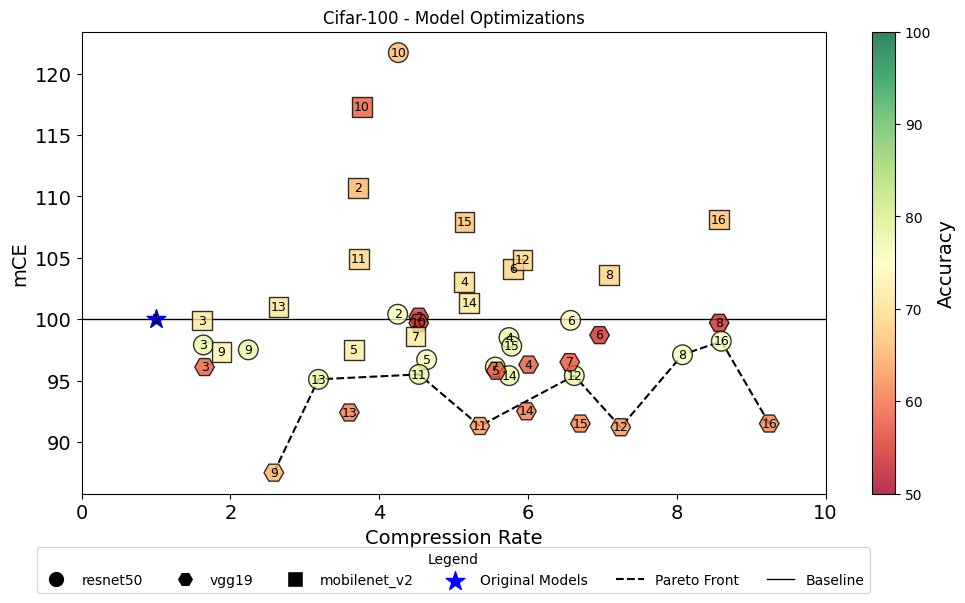

In [ ]:
colors = {
    'resnet50': {
        "marker": 'o',
        "color": '#1f77b4',
    },
    'vgg19': {
        "marker": 'H',
        "color": '#ff7f0e',
    },
    # 'mobilenet': {
    #     "marker": 's',
    #     "color": '#2ca02c',
    # },
    'mobilenet_v2': {
        "marker": 's',
        "color": '#d62728'
    }
}


legends = {
    "Original": '1',
    'Quantization Int8': '2',
    'Pruning': '3',
    'Pruning with Quantization Int8': '4',
    'Clustering': '5',
    'Clustering with Quantization Int8': '6',
    'Pruning with Clustering': '7',
    'Pruning with Clustering with Quantization Int8': '8',
    'QAT':'9',
    'QAT with Quantization Int8': '10',
    'CQAT': '11',
    'CQAT with Quantization Int8': '12',
    'PQAT': '13',
    'PQAT with Quantization Int8': '14',
    'PCQAT': '15',
    'PCQAT with Quantization Int8': '16',
}

df_final = df_cifar100_final[~(df_cifar100_final.index.get_level_values('Model') == 'mobilenet')]
all_x_coords = df_final["Compression Rate"].values
all_y_coords = df_final["mCE"].values
all_z_coords = df_final["Accuracy"].values

combined_solutions = np.column_stack([
    all_x_coords,
    all_y_coords,
    all_z_coords
    ])

pareto_front = find_pareto_front(combined_solutions, minimization_objectives=[False, True, False])
ordened_x = np.argsort(pareto_front[:, 0])
pareto_front = pareto_front[ordened_x]
print(pareto_front)
types = df_final.index.get_level_values('Type').unique()
v_min = 50.0
v_max = 100.0

plt.figure(figsize=(12, 6))

plt.scatter([1], [100], color='blue', label='Original Models', marker='*', s=200,zorder=10)

model_markers = []
for model_name in colors.keys():
  model_markers.append(plt.Line2D(
      [0], [0],
      marker=colors[model_name]["marker"],  # A simple marker to represent the annotated point
      color='w',   # White color as the actual text is black
      label=model_name, # Label for the legend
      markerfacecolor='k', # Black marker face color
      markersize=12
  ))
  data = df_final.loc[model_name]
  x_coords = data["Compression Rate"]
  y_coords = data["mCE"]
  z_coords = data["Accuracy"]
  scatter = plt.scatter(
      x=x_coords[1:],
      y=y_coords[1:],
      c=z_coords[1:],
      s=200,
      cmap='RdYlGn',
      edgecolor='k',
      marker=colors[model_name]["marker"],
      alpha=0.8,
      vmin=v_min,
      vmax=v_max,
      # label=model_name
    )
  for type_name, row in data.iterrows():
    current_point = (row['Compression Rate'], row['mCE'], row['Accuracy'])
    letter = legends[type_name]
    plt.text(
        row['Compression Rate'],
        row['mCE'],
        letter,
        fontsize=9,
        ha='center',
        va='center',
        color='black',
        zorder=10
    )

cbar = plt.colorbar(scatter)
cbar.set_label("Accuracy", fontsize=14)

annotation_proxies = []

for key, value in legends.items():
  annotation_proxies.append(plt.Line2D(
      [0], [0],
      marker='None',  # A simple marker to represent the annotated point
      color='w',   # White color as the actual text is black
      label=f'{value} - {key}', # Label for the legend
      markerfacecolor='k', # Black marker face color
      markersize=8
  ))

plt.plot(
    pareto_front[:, 0],
    pareto_front[:, 1],
    color='black',
    linestyle='--',
    markersize=8,
    label='Pareto Front',
    zorder=0
)

plt.plot([0, 10], [100, 100], color='black', label='Baseline', linewidth=1, zorder=0)
# Combine existing legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Add the annotation proxies to the handles and labels
handles = model_markers + handles
# handles.extend(annotation_proxies)
labels = [proxy.get_label() for proxy in model_markers] + labels
# labels.extend([proxy.get_label() for proxy in annotation_proxies])


plt.xlim(0, 10)
plt.title("Cifar-100 - Model Optimizations")
plt.xlabel("Compression Rate", fontsize=14)
plt.ylabel("mCE", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(handles, labels, loc='upper center', title="Legend", bbox_to_anchor=(0.5, -0.1), ncol=6)
plt.savefig("cifar100.pdf", dpi=300, bbox_inches='tight')
plt.show()